<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Read-Raw-Data" data-toc-modified-id="Read-Raw-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Read Raw Data</a></span></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

%matplotlib inline

SAMPLE_NUMBER = 213

from sklearn.linear_model import LinearRegression # linear regression
from sklearn.model_selection import train_test_split # split dataset into train & testing
from sklearn.metrics import mean_squared_error # calculate error

from sklearn.model_selection import train_test_split # split dataset into train & testing
from sklearn.metrics import max_error, mean_absolute_error # calculate error

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression # linear regression

In [2]:
def read_filename(filename):

	# read table
	df = pd.read_csv(filename, sep='\t', decimal='.', header=None)

	# EG, FILENAME='PL_PC_records/PL and PC record-535-b-2.txt' --> ID_STRING='535-b-2.txt'
	id_string = filename.split('/')[2]
	cc = id_string.split('_') # split into parts with - inbetween

	print (cc)

	wavelength = cc[0] # wavelength
	location = cc[3] # background (b) or nv-center (nv)
	voltage = cc[2]

	# file has rows for columns, thus transpose
	df = df.transpose()

	# assign column meaning
	df['Laser Power (V)'] = df[0] # the header became the index after transposition
	df['PL (counts/s)'] = df[1]
	df['PC (pA)'] = df[2]

	# make the index a simple counter
	df = df.reset_index()

	# keep columns of interest
	df = df[['Laser Power (V)', 'PL (counts/s)', 'PC (pA)']]

	# assign identifiers to dataframe
	df['Wavelength'] = int(wavelength)
	df['Location'] = location
	df['Voltage'] = voltage

	df['Laser Power (V)'] = df['Laser Power (V)'].astype(float)
	df['PL (counts/s)'] = df['PL (counts/s)'].astype(float)
	df['PC (pA)'] =  df['PC (pA)'].astype(float)

	return df, wavelength, location, voltage

def read_experiment(fg, bg, plot=True):
	nv_df_0V, _ , _ , _ = read_filename(fg)
	nv_df_0V_BG, _ , _ , _ = read_filename(bg)

	# showcase Laser Power x PL
	if plot:
		fig, (ax1,ax2) = plt.subplots(1,2, figsize=(7,2.5))  # 1 row, 2 columns
		nv_df_0V.plot.scatter(x='Laser Power (V)', y='PL (counts/s)', ax=ax1, title=f"NV-Center {SAMPLE_NUMBER}  - Voltage to PhotoLuminesence")
		nv_df_0V_BG.plot.scatter(x='Laser Power (V)', y='PL (counts/s)', ax=ax2, title=f"Background {SAMPLE_NUMBER}  - Voltage to PhotoLuminesence")

	# plt.plot(X_test, y_pred,color='k')

	return nv_df_0V, nv_df_0V_BG

def read_experiment_w_exp_volt(wavelength, experiment_n, volt, background_picks, plot=False):
	
	background_n = background_picks[wavelength][volt]

	filename_fg = f'./SAT_CURVE/{wavelength}_NV_{volt}_fg_{experiment_n}.txt'
	filename_bg = f'./SAT_CURVE/{wavelength}_NV_{volt}_bg_{background_n}.txt'

	df_fg, df_bg = read_experiment(filename_fg, filename_bg, plot)

	df = fit_background(df_fg, df_bg, plot, wavelength)

	df['wavelength'] = wavelength
	df['experiment #'] = experiment_n
	df['sample'] = SAMPLE_NUMBER

	return df #, df_fg, df_bg

def fit_background(df_nv_fg, df_nv_bg, plot=True, wavelength=540):

	df_nv_bg = df_nv_bg.dropna()
	
	df_nv_bg = df_nv_bg.loc[df_nv_bg['Laser Power (V)'] < cutoff_voltage[int(wavelength)], :]

	# select first and last few items from background to make a better fit
	# df_nv_bg = pd.concat([df_nv_bg.head(5), df_nv_bg.tail(5)]).reset_index(drop=True)
	
	# fit background PL(V) function, should be linear
	X = df_nv_bg['Laser Power (V)'].to_numpy()
	y = df_nv_bg['PL (counts/s)'].to_numpy()

	# reshape data - [a,b,c,d] -> [[a], [b], [c], [d]] (because we have 1 feature for X)
	X = X.reshape(-1, 1)

	# fit regression
	reg = LinearRegression().fit(X, y)

	# predict on unseen values (X_test)
	y_pred = reg.predict(X)

	# plot input values, and fit
	if plot:
		fig, (ax1) = plt.subplots(1,1, figsize=(5,2.5))  # 1 row, 2 columns
		plt.scatter(X, y,color='r') 
		plt.plot(X, y_pred,color='k')

	# conver the column into a readily base for regressing
	laser_power_nv = df_nv_fg['Laser Power (V)'].to_numpy().reshape(-1,1)

	# apply PL-count Regression
	df_nv_fg['PL_background'] = reg.predict(laser_power_nv)

	# subtract background counts from NV counts
	df_nv_fg['PL_actual (#/s)'] = df_nv_fg['PL (counts/s)'] - df_nv_fg['PL_background']

	if plot:
		fig, (ax1) = plt.subplots(1,1, figsize=(5,2.5))  # 1 row, 2 columns
		df_nv_fg.plot.scatter(x='Laser Power (V)', y='PL_actual (#/s)', ax=ax1, title=f"NV-Center {SAMPLE_NUMBER} - Saturation Curve - Power vs PhotoLuminesence")

	return df_nv_fg

def map_to_mw(wavelength, df):

	# pick out wavelength
	fit = wavelength_dict[wavelength]

	# apply converion to df
	df['Laser Power (mW)'] = fit.predict(df['Laser Power (V)'].to_numpy().reshape(-1,1))

	return df

def perform_fit(curve_fit, df, fit_kwargs):
	# df_0V = nv_df_0V
	fit_0, _ = get_fit_params(func_to_fit, df, fit_kwargs)
	fig, (ax1) = plt.subplots(1,1, figsize=(14,6))  # 1 row, 2 columns
	df.plot.scatter(x='Laser Power (mW)', y='PL_actual (#/s)', c='green', ax=ax1, legend=True, title=f"NV-Center {SAMPLE_NUMBER} - Laser Power (V) vs PhotoLuminesence")

	x_1 = df['Laser Power (mW)'].to_numpy()

	plt.plot(x_1, curve_fit(x_1, *fit_0), 'g--', c='green', label='NV 0V - fit: b=%5.3f, c=%5.3f, d=%5.3f, e=%5.3f' % tuple(fit_0))

	ax1.set_title(f"#{SAMPLE_NUMBER} NV-Center - Natural Log PL -  Voltage Sweep at varying laser powers - 535nm")
	ax1.set_xlabel("Laser Power (mW)")
	ax1.set_ylabel("Photoluminescence (#/s)")
	ax1.legend()
	ax1.grid(True)

	plt.legend()

def perform_fit_ax(curve_fit, ax1, df, fit_kwargs, color='green', scatter=True, legend=False, fit_label=""):
	# df_0V = nv_df_0V
	fit_0, _ = get_fit_params(curve_fit, df, fit_kwargs)

	exp_n = df['experiment #'][0]

	if scatter:
		df.plot.scatter(x='Laser Power (mW)', y='PL_actual (#/s)', c=color, ax=ax1, legend=True, title=f"NV-Center {SAMPLE_NUMBER} - Laser Power (V) vs PhotoLuminesence")

	x_1 = df['Laser Power (mW)'].to_numpy()
	x_1.sort()

	label = f'NV ({exp_n}) - fit: e=%5.3f, ke=%5.3f, k8=%5.3f, kd=%5.3f' % tuple(fit_0)
	if fit_label != "":
		label = fit_label
	plt.plot(x_1, curve_fit(x_1, *fit_0), 'g--', c=color, label=label)

	ax1.set_title(f"#{SAMPLE_NUMBER} NV-Center - Natural Log PL -  Voltage Sweep at varying laser powers - 535nm")
	ax1.set_xlabel("Laser Power (mW)")
	ax1.set_ylabel("Photoluminescence (#/s)")

	if legend:
		ax1.legend()
	ax1.grid(True)

	if legend:
		plt.legend()

	return fit_0[2]

def get_fit_params(func_to_fit, df, kwargs):
	# data
	x = df['Laser Power (mW)'].to_numpy()
	y = df['PL_actual (#/s)'].to_numpy()

	# function fit
	popt, pcov = curve_fit(func_to_fit, x, y, **kwargs)
	
	return popt, pcov

In [3]:
# 535 - laser power fitting
x = np.array([0.10334, 3.20574]).reshape(-1, 1)
y = [1.51800, 60.6]
laser_power_v_to_mW_535 = LinearRegression().fit(x, y)

# 540 - laser power fittingx
x = np.array([0.413991, 8.34689]).reshape(-1, 1)
y = [2.86, 61.1]
laser_power_v_to_mW_540 = LinearRegression().fit(x, y)

# 545 - laser power fittingx
x = np.array([0.394525, 5.7888]).reshape(-1, 1)
y = [3.82, 60.2]
laser_power_v_to_mW_545 = LinearRegression().fit(x, y)

# 550 - laser power fittingx
x = np.array([0.361688, 9.14476]).reshape(-1, 1)
y = [2.16, 58.9]
laser_power_v_to_mW_550 = LinearRegression().fit(x, y)

# 555 - laser power fittingx
x = np.array([0.13036, 3.31927]).reshape(-1, 1)
y = [1.408, 53.7]
laser_power_v_to_mW_555 = LinearRegression().fit(x, y)

# 560 - laser power fittingx
x = np.array([0.285492, 5.43359]).reshape(-1, 1)
y = [2.98, 74.0]
laser_power_v_to_mW_560 = LinearRegression().fit(x, y)

# 565 - laser power fittingx
x = np.array([0.20563, 5.67628]).reshape(-1, 1)
y = [1.88, 78.6]
laser_power_v_to_mW_565 = LinearRegression().fit(x, y)

# 570- laser power fittingx
x = np.array([0.20628, 9.17424]).reshape(-1, 1)
y = [1.129, 60.9]
laser_power_v_to_mW_570 = LinearRegression().fit(x, y)

wavelength_dict = {
	535: laser_power_v_to_mW_535,
	540: laser_power_v_to_mW_540,
	545: laser_power_v_to_mW_545,
	550: laser_power_v_to_mW_550,
	555: laser_power_v_to_mW_555,
	560: laser_power_v_to_mW_560,
	565: laser_power_v_to_mW_565,
	570: laser_power_v_to_mW_570,
}

In [4]:
cutoff_voltage = {
	535: 2.2,
	540: 5.55,
	545: 4.1,
	550: 6.55,
	555: 2.55,
	560: 3.10,
	565: 3.15,
	570: 6.05,
}

## Read Raw Data

In [5]:
background_picks = {
	'535': {
		'0V':'2', # good from previous week
		# '0V':'5', # with nuked optics
	},
	'540': {
		'0V':'2',
		'm10V':'1',
		'10V':'1',
	},
	'545': {
		'0V':'1',
	},
	'550': {
		'0V':'2',
	},
	'555': {
		'0V':'2',
	},
	'560': {
		'0V':'2',
	},
	'565': {
		'0V':'6',
	},
	'570': {
		'0V':'5',
	},
}

to_exclude = {
	'565': [1,2,3,4,5,6]
}

['570', 'NV', '0V', 'fg', '6.txt']
['570', 'NV', '0V', 'bg', '5.txt']


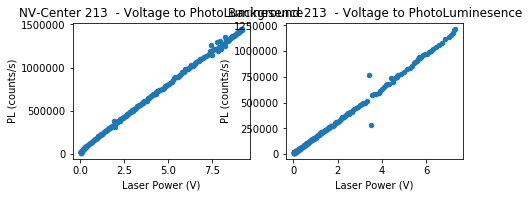

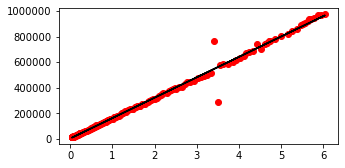

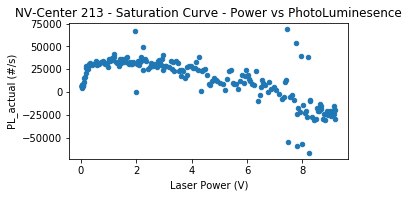

In [6]:
df = read_experiment_w_exp_volt('570', '6', '0V', background_picks, True)

In [73]:
directory = 'SAT_CURVE'

# we'll be storing all experiments in a dictionary
dfs_wavelength = {}
all_saturation_curves = []

# go through all files in folder
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)

    # checking if it is a file
    if os.path.isfile(f):

        # take out the folder from the filename
        filename = f.split('/')[1]
        
        # obtain parameters to filename
        params = filename.split('_')

        if (len(params)<5):
            continue

        if (params[3] == 'bg'):
            continue

        # pick up parameters for experiment identification 
        wavelength = params[0]
        voltage = params[2]
        exp = params[4].split('.')[0]

        print (wavelength, voltage, exp)

        # read them all
        df = read_experiment_w_exp_volt(wavelength, exp, voltage, background_picks)

        # Convert voltage to mW, using our linear mapping
        df = map_to_mw(int(wavelength), df)

        all_saturation_curves.append(df)

570 0V 6
['570', 'NV', '0V', 'fg', '6.txt']
['570', 'NV', '0V', 'bg', '5.txt']
565 0V 6
['565', 'NV', '0V', 'fg', '6.txt']
['565', 'NV', '0V', 'bg', '6.txt']
565 0V 7
['565', 'NV', '0V', 'fg', '7.txt']
['565', 'NV', '0V', 'bg', '6.txt']
570 0V 5
['570', 'NV', '0V', 'fg', '5.txt']
['570', 'NV', '0V', 'bg', '5.txt']
565 0V 5
['565', 'NV', '0V', 'fg', '5.txt']
['565', 'NV', '0V', 'bg', '6.txt']
565 0V 4
['565', 'NV', '0V', 'fg', '4.txt']
['565', 'NV', '0V', 'bg', '6.txt']
570 0V 4
['570', 'NV', '0V', 'fg', '4.txt']
['570', 'NV', '0V', 'bg', '5.txt']
570 0V 1
['570', 'NV', '0V', 'fg', '1.txt']
['570', 'NV', '0V', 'bg', '5.txt']
565 0V 1
['565', 'NV', '0V', 'fg', '1.txt']
['565', 'NV', '0V', 'bg', '6.txt']
565 0V 3
['565', 'NV', '0V', 'fg', '3.txt']
['565', 'NV', '0V', 'bg', '6.txt']
570 0V 3
['570', 'NV', '0V', 'fg', '3.txt']
['570', 'NV', '0V', 'bg', '5.txt']
570 0V 2
['570', 'NV', '0V', 'fg', '2.txt']
['570', 'NV', '0V', 'bg', '5.txt']
565 0V 2
['565', 'NV', '0V', 'fg', '2.txt']
['565', 

In [74]:
dfs_40mw = []
dfs_80mw = []

for ii, df in enumerate(all_saturation_curves): # wavelength
    tmp = df.loc[df['PL_actual (#/s)'] > 0,:]
    tmp = tmp.loc[tmp['PL_actual (#/s)'] < 100400,:]
    
    df_40mw = tmp.loc[tmp['Laser Power (mW)'] < 40, :]
    df_80mw = tmp.loc[tmp['Laser Power (mW)'] < 80, :]

    dfs_40mw.append(df_40mw.reset_index(drop=True))
    dfs_80mw.append(df_80mw.reset_index(drop=True))

In [12]:
all_saturation_curves[0].head()

,Laser Power (V),PL (counts/s),PC (pA),Wavelength,Location,Voltage,PL_background,PL_actual (#/s),wavelength,experiment #,sample,Laser Power (mW)
0,0.049382,18590.435095,-0.784867,570,fg,0V,12635.741985,5954.693110,570,6,213,0.083283
1,0.049338,19741.441024,-0.785332,570,fg,0V,12628.745193,7112.695831,570,6,213,0.082990
2,0.049491,19171.698921,-0.785926,570,fg,0V,12653.074948,6518.623973,570,6,213,0.084009
3,0.049501,19057.913774,-0.786726,570,fg,0V,12654.665128,6403.248646,570,6,213,0.084076
4,0.050117,19867.127292,-0.787937,570,fg,0V,12752.620218,7114.507074,570,6,213,0.088182


In [44]:
dfs_40mw[2]['Wavelength'][0]

565

In [49]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # <--- This is important for 3d plotting 
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [23]:
%matplotlib widget

In [78]:
to_disregard = [
	['535', '0V', '6'],

	['540', 'm10V', '1'],

	['540', '10V', '6'],

	['540', '0V', '7'],
	['540', '0V', '6'],
	['540', '0V', '2'],

	['545', '0V', '5'],
	['545', '0V', '6'],
	
	['550', '0V', '1'],
	['550', '0V', '3'],
	['550', '0V', '5'],

	['555', '0V', '5'],

	
	['560', '0V', '3'],
	['560', '0V', '4'],
	['560', '0V', '1'],
	['560', '0V', '6'],

	['565', '0V', '16'],
	['565', '0V', '14'],
	['565', '0V', '2'],
	['565', '0V', '13'],
	['565', '0V', '15'],
	['565', '0V', '12'],
	['565', '0V', '11'],

	['565', '0V', '3'],
	['565', '0V', '9'],
	['565', '0V', '6'],
	['565', '0V', '5'],
	['565', '0V', '10'],
	# ['565', '0V', 13],

	['570', '0V', '6'],
	['570', '0V', '5'],
	['570', '0V', '4'],
	['570', '0V', '1'],

]

<IPython.core.display.Javascript object>


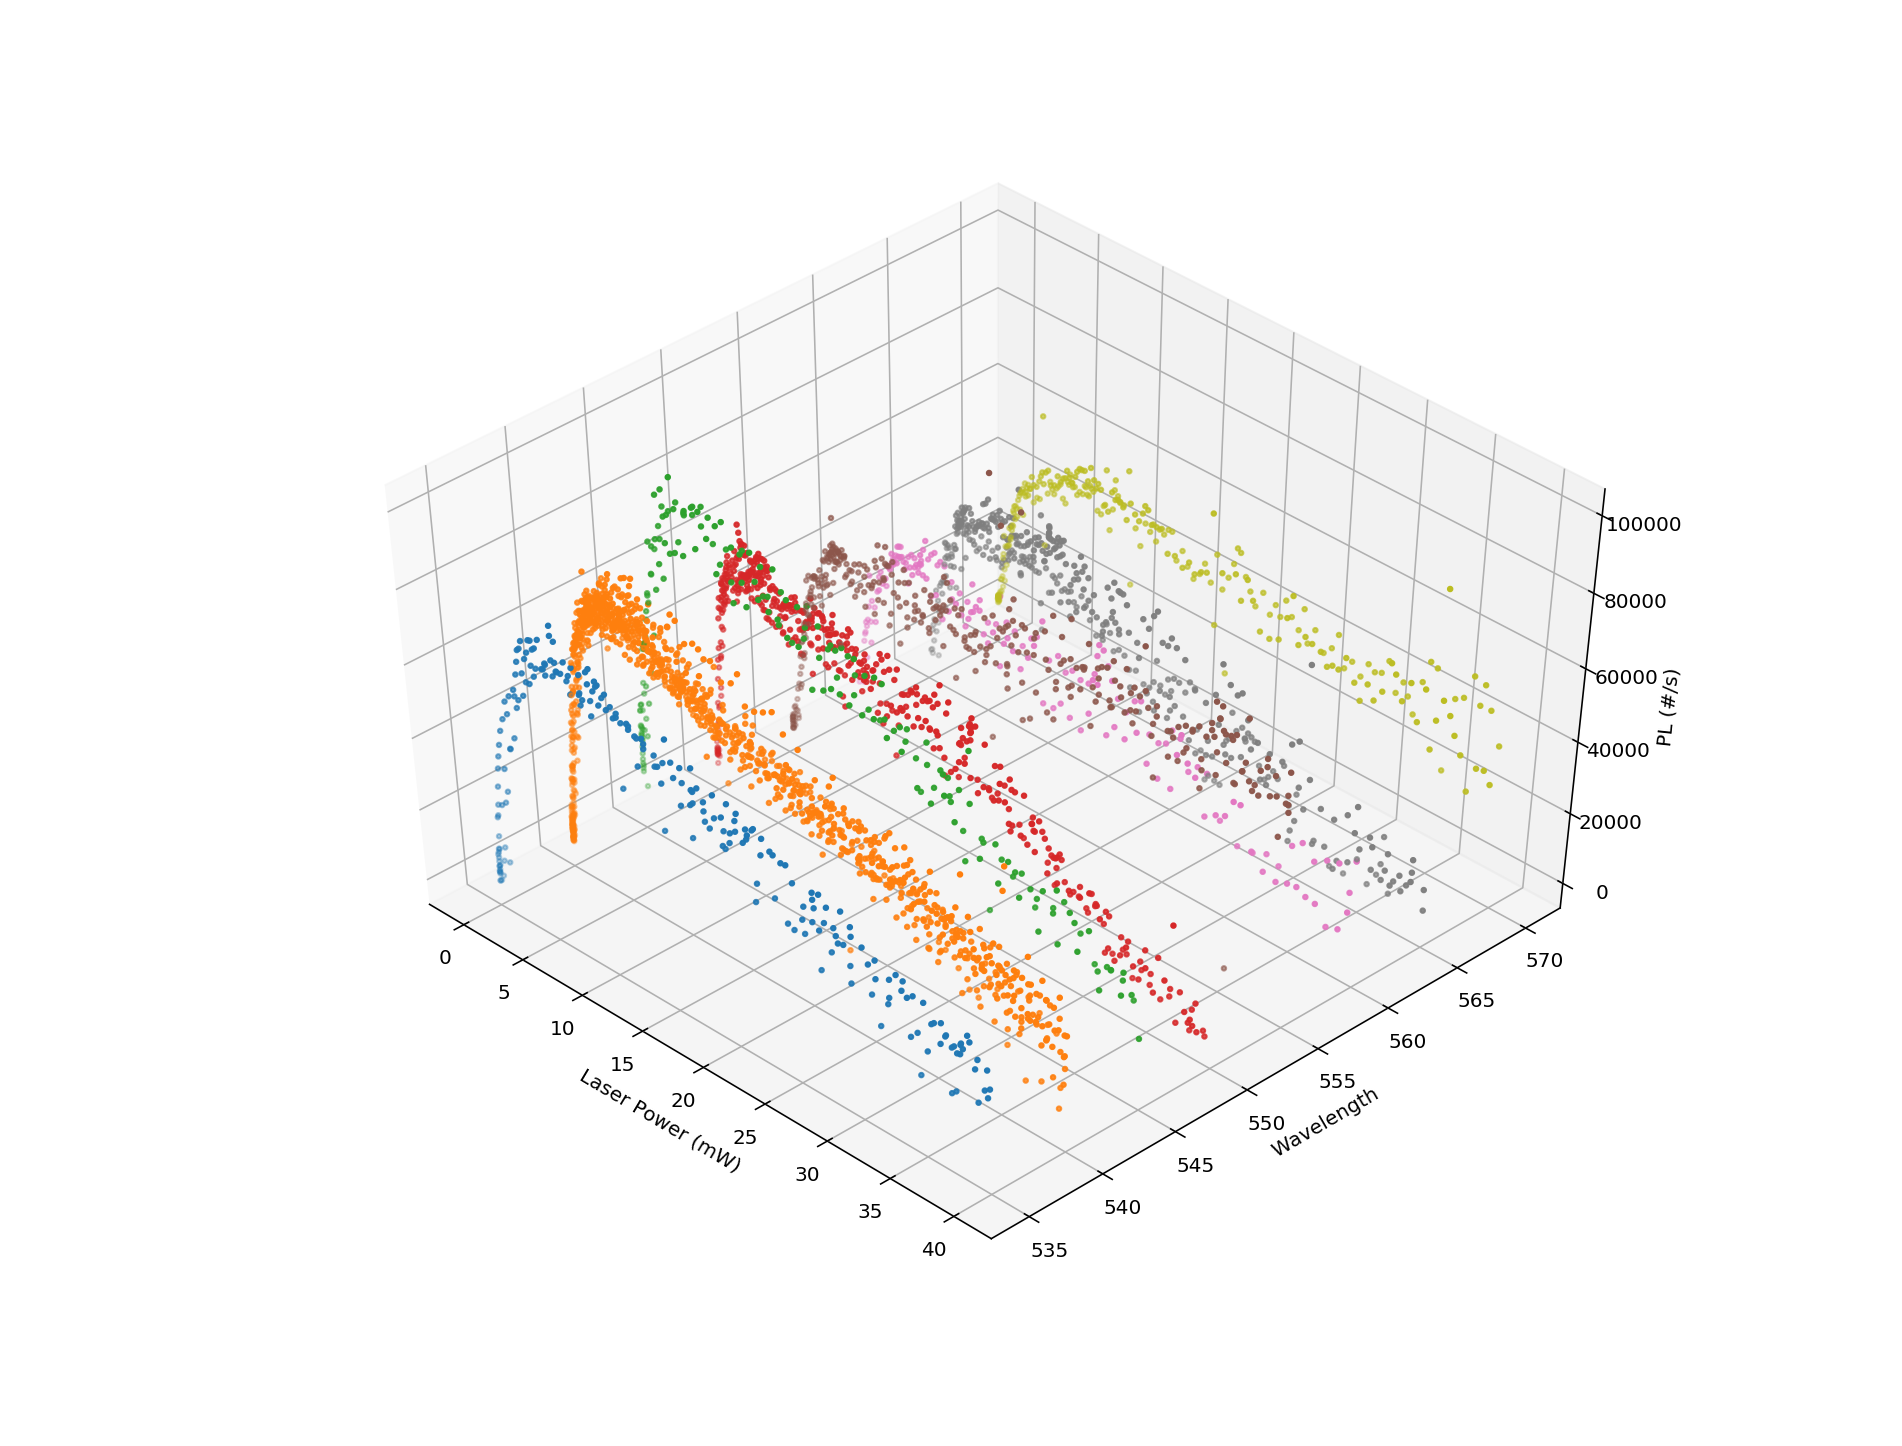

['570', '0V', '6']
['565', '0V', '6']
['565', '0V', '7']
['570', '0V', '5']
['565', '0V', '5']
['565', '0V', '4']
['570', '0V', '4']
['570', '0V', '1']
['565', '0V', '1']
['565', '0V', '3']
['570', '0V', '3']
['570', '0V', '2']
['565', '0V', '2']
['540', '0V', '8']
['565', '0V', '15']
['565', '0V', '14']
['560', '0V', '1']
['540', '0V', '6']
['540', '0V', '4']
['560', '0V', '3']
['565', '0V', '16']
['560', '0V', '2']
['540', '0V', '5']
['540', '0V', '1']
['560', '0V', '6']
['565', '0V', '13']
['565', '0V', '12']
['540', '0V', '2']
['560', '0V', '5']
['565', '0V', '10']
['565', '0V', '11']
['560', '0V', '4']
['540', '0V', '3']
['540', '0V', '1']
['555', '0V', '1']
['540', '0V', '2']
['555', '0V', '2']
['555', '0V', '3']
['540', '0V', '3']
['540', '0V', '7']
['540', '0V', '6']
['555', '0V', '6']
['555', '0V', '4']
['540', '0V', '4']
['540', '0V', '5']
['555', '0V', '5']
['535', '0V', '3']
['550', '0V', '7']
['540', '0V', '5']
['540', '0V', '4']
['550', '0V', '6']
['545', '0V', '6']
['535

In [85]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

plasma = cm.get_cmap('tab10', 9)
colors = plasma(range(9))

color_map = { (i*5 + 535) : colors[i] for i in range(8)}

for ii, df in enumerate(dfs_40mw):
    xs = df['Laser Power (mW)']    
    ys = df['Wavelength'][0]
    zs = df['PL_actual (#/s)']
    
    v = df['Voltage'][0]
    exp = df['experiment #'][0]
    
    print ([str(ys), str(voltage), str(exp)])
    
    if [str(ys), voltage, exp] in to_disregard:
        continue
    
    ax.scatter(xs, ys, zs, marker='.', color=color_map[ys])

ax.set_xlabel('Laser Power (mW)')
ax.set_ylabel('Wavelength')
ax.set_zlabel('PL (#/s)')

plt.show()

<IPython.core.display.Javascript object>


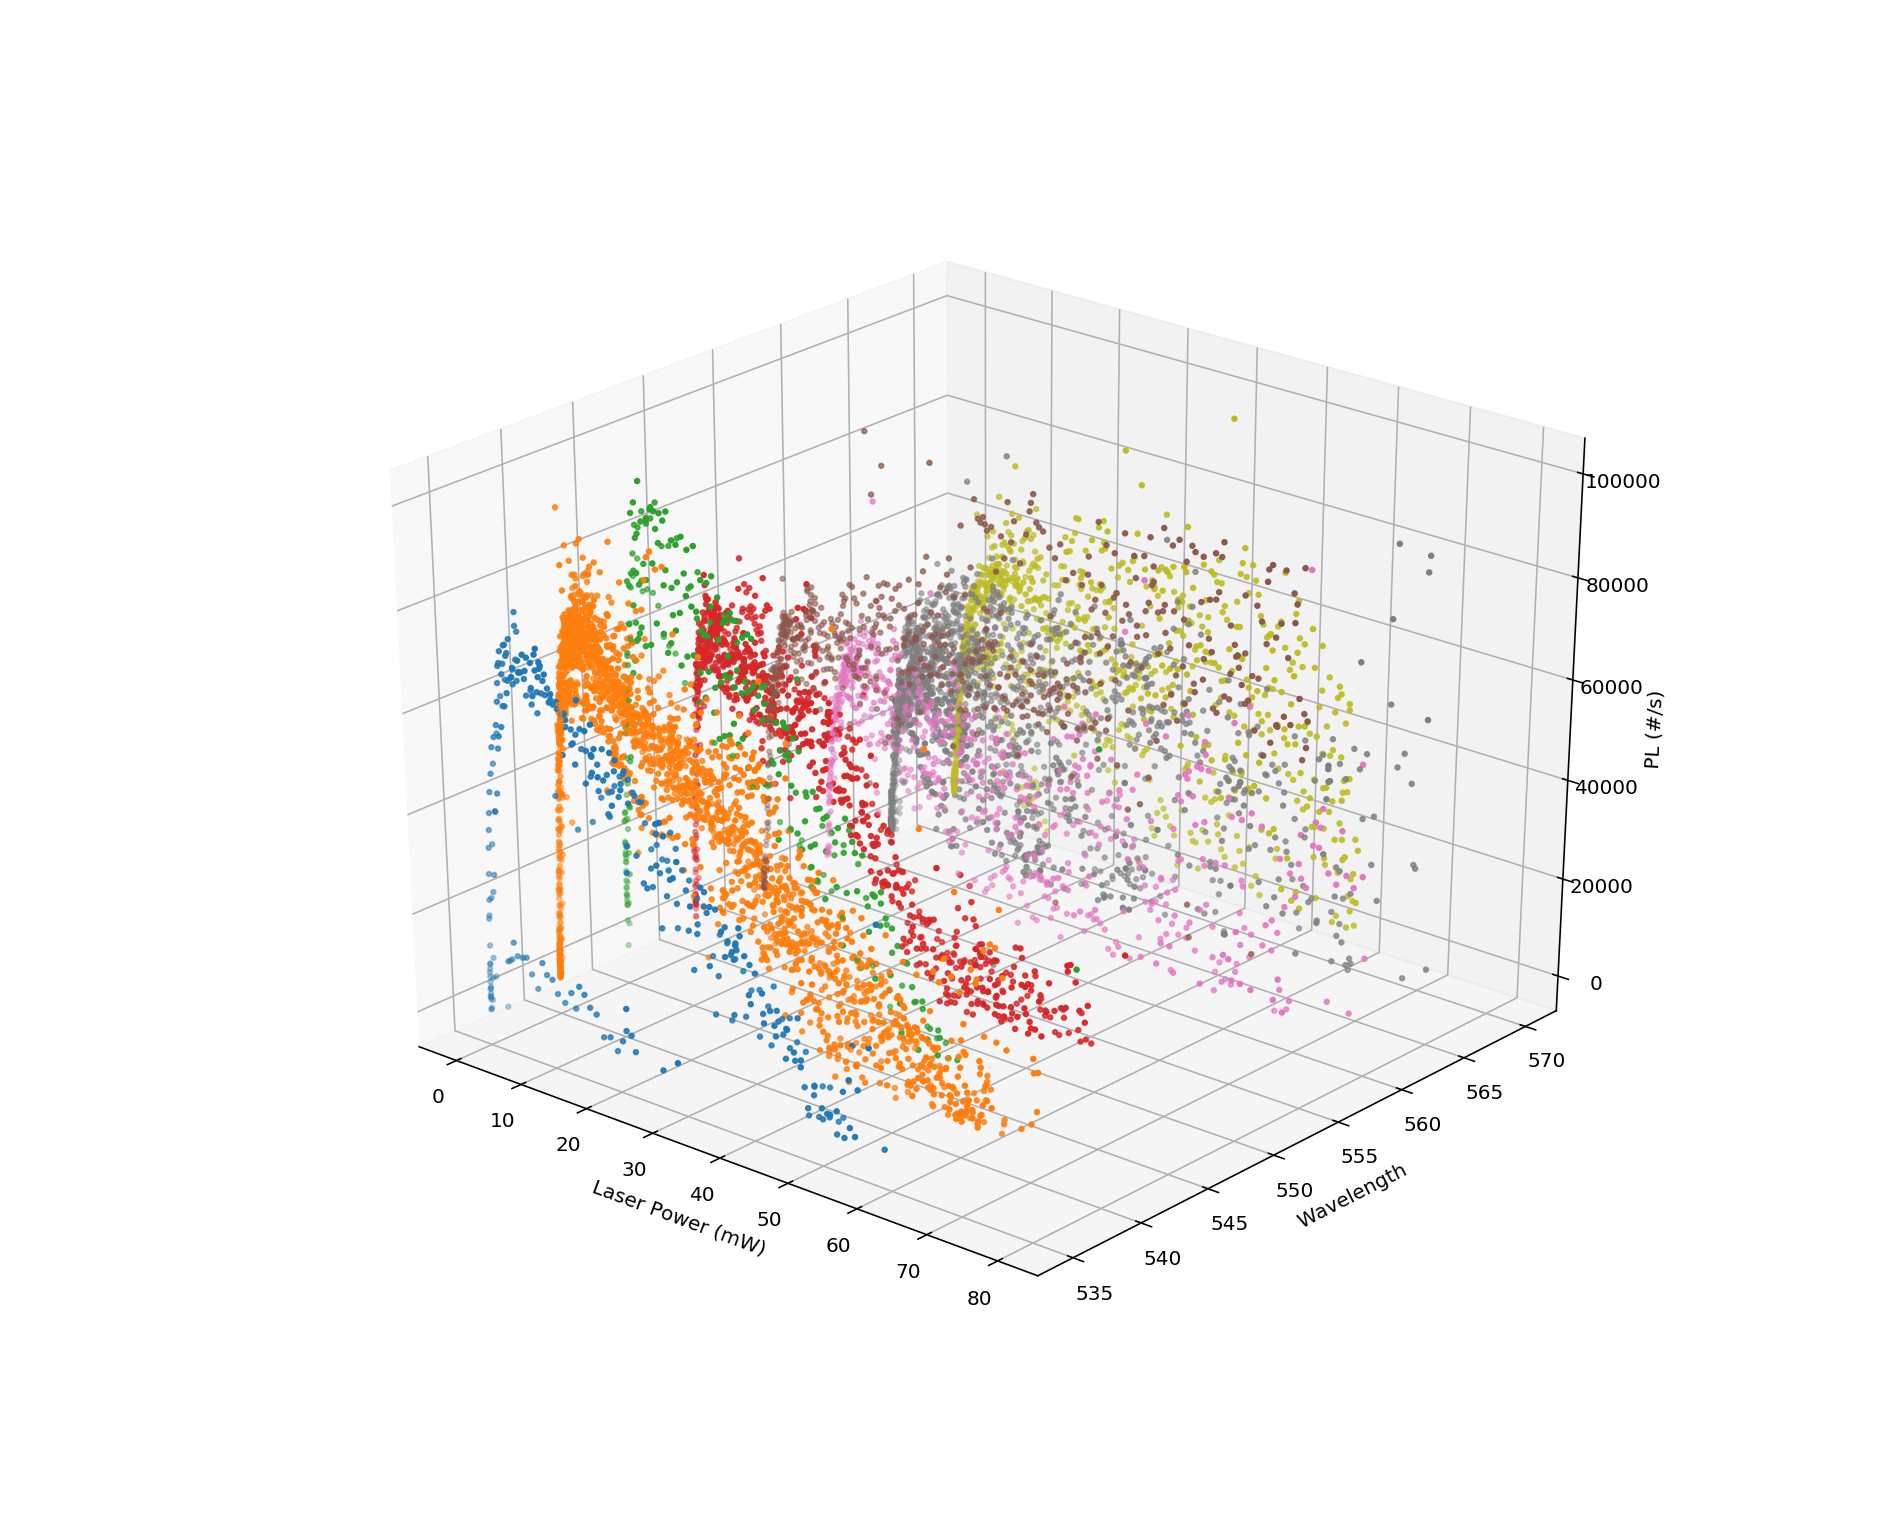

In [54]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

plasma = cm.get_cmap('tab10', 9)
colors = plasma(range(9))

color_map = { (i*5 + 535) : colors[i] for i in range(8)}

for ii, df in enumerate(dfs_80mw):
    xs = df['Laser Power (mW)']    
    ys = df['Wavelength'][0]
    zs = df['PL_actual (#/s)']
    
    ax.scatter(xs, ys, zs, marker='.', color=color_map[ys])

ax.set_xlabel('Laser Power (mW)')
ax.set_ylabel('Wavelength')
ax.set_zlabel('PL (#/s)')

plt.show()